## Display saliency map

Based on [pytorch-grad-cam](https://github.com/jacobgil/pytorch-grad-cam), in particular the `cam.py` example cli app.

The desired gradcam heatmap from [Detection of signs of disease in external photographs of the eyes via deep learning](https://www.nature.com/articles/s41551-022-00867-5) for detecting Diabetic Retinopathy can be seen [here](https://user-images.githubusercontent.com/296876/220427626-728678c8-2e62-4185-a731-48e406f84f02.png).


In [193]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms
from helper_functions import initialize_model
from PIL import Image
import cv2
import numpy as np
import os
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import preprocess_image
from torchvision.models import resnet50

## Autoreload

In [194]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:

images_root = './EyePacs1KDataset/587_587_resized_images'

# These images are from the training set when training on all eyepaks1k images
training_images = [
    "878968_1256244_13026676_Left External.JPG",
    '599078_1453469_14443867_Right External.jpg',
    '935873_1343143_13668663_Left External.jpg'
]
training_images = [os.path.join(images_root, path) for path in training_images]

# Validation set when training on all eyepaks1k images
validation_images = [
    "977742_1407093_14130039_Left External.jpg",
    "507255_1279434_13205086_Left External.jpg"
]
validation_images = [os.path.join(images_root, path) for path in validation_images]


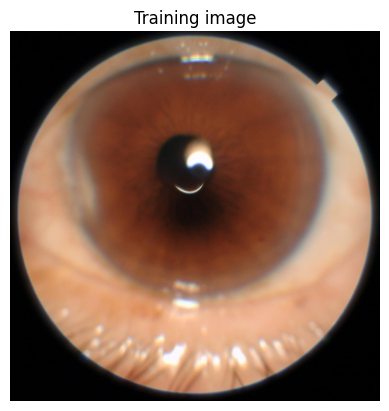

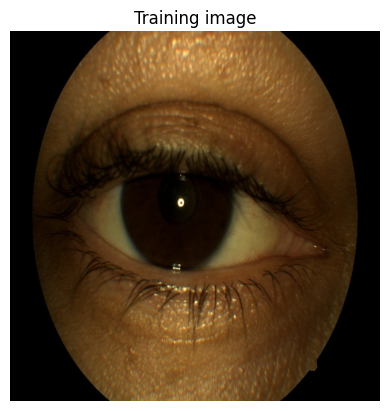

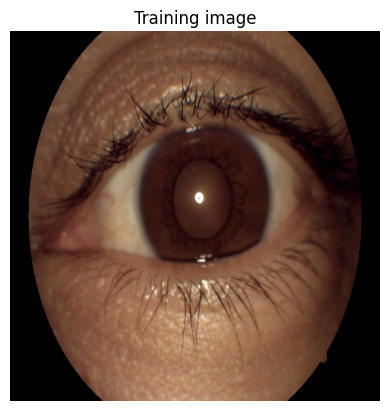

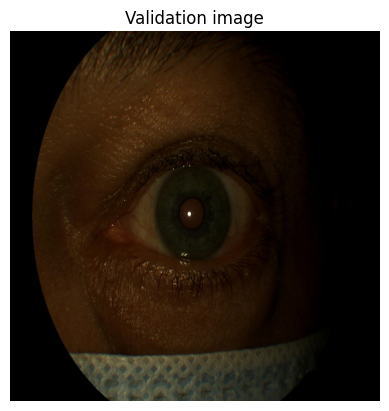

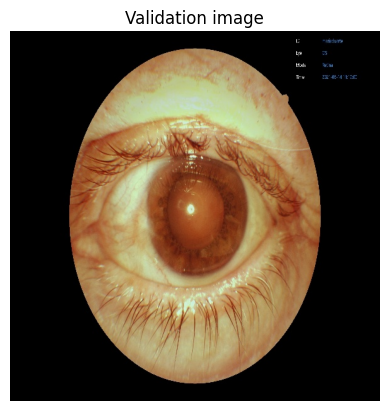

In [209]:
for image_path in training_images:
    plt.figure()
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.title('Training image')
    plt.axis('off');
for image_path in validation_images:
    plt.figure()
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.title('Validation image')
    plt.axis('off');

In [213]:
model_path = "model-epoch-70.pt"
model = initialize_model("resnet", 2, final_dropout=0.2, use_pretrained=False)
                    
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

## Visualize

Unfortunately it looks like it's hitting the same bug as described here: https://github.com/MisaOgura/flashtorch/issues/42

## Gradcam

https://github.com/jacobgil/pytorch-grad-cam

In [211]:

def visualize_image_gradcam(modle, input_image_path):

    target_layers = [model.layer4[-1]]  # This is what is recommended for resnet18 

    # Open image and convert from bgr to rgb
    rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]

    rgb_img = np.float32(rgb_img) / 255

    input_tensor = preprocess_image(rgb_img,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

    # Construct the CAM object once, and then re-use it on many images:
    with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:

        # You can also use it within a with statement, to make sure it is freed,
        # In case you need to re-create it inside an outer loop:
        # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
        #   ...

        # We have to specify the target we want to generate
        # the Class Activation Maps for.
        # If targets is None, the highest scoring category
        # will be used for every image in the batch.
        # Here we use ClassifierOutputTarget, but you can define your own custom targets
        # That are, for example, combinations of categories, or specific outputs in a non standard model.

        #targets = [ClassifierOutputTarget(1)]  # 1 = "has DR"

        # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        # grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)

        # In this example grayscale_cam has only one image in the batch:
        grayscale_cam = grayscale_cam[0, :]

        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
        return visualization


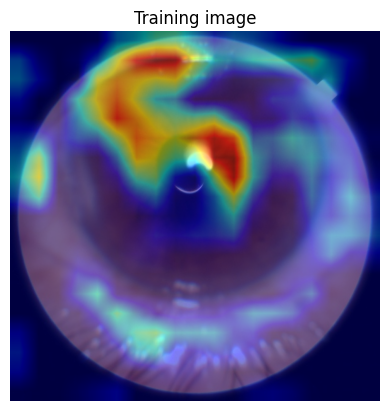

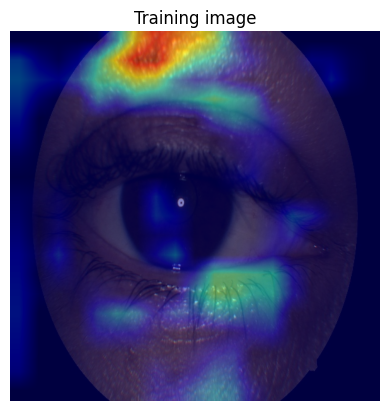

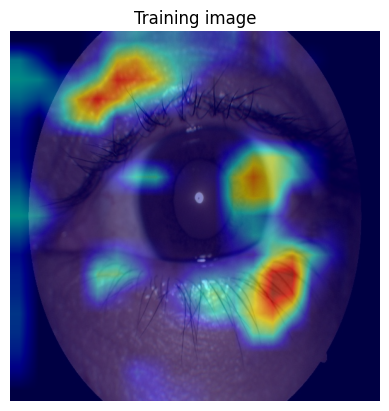

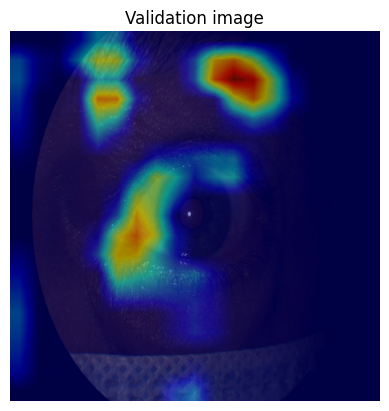

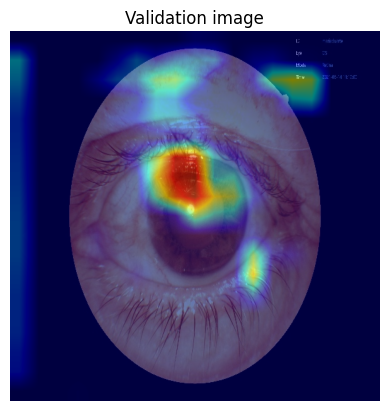

In [212]:
for image_path in training_images:
    plt.figure()
    visualized = visualize_image_gradcam(model, image_path)
    plt.imshow(visualized)
    plt.title('Training image')
    plt.axis('off');
for image_path in validation_images:
    plt.figure()
    visualized = visualize_image_gradcam(model, image_path)
    plt.imshow(visualized)
    plt.title('Validation image')
    plt.axis('off');